In [142]:
import json
import logging
from collections import OrderedDict
from typing import Optional

import coloredlogs
from ph4_walkingpad.profile import Profile, calories_walk2_minute, calories_rmrcb_minute
from ph4_walkingpad.analysis import StatsAnalysis

import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)
coloredlogs.CHROOT_FILES = []
coloredlogs.install(level=logging.INFO)

In [2]:
an = StatsAnalysis()
an.profile_file = '/Users/dusanklinec/workspace/ph4-walkingpad/profile.json'
an.stats_file = '/Users/dusanklinec/walking.json'
an.load_profile()
an.load_stats(6, collect_details=True)

for ix, m in enumerate(an.loaded_margins):
    print('============================================= Margins: %s, segms: %s' % (ix,len(m)))
    print(json.dumps(an.remove_records([m])[0], indent=2))


============================================= Margins: 0, segms: 2
[
  {
    "time": 0,
    "dist": 0,
    "steps": 0,
    "speed": 0,
    "app_speed": 0,
    "belt_state": 0,
    "controller_button": 0,
    "manual_mode": 1,
    "raw": "f8a200000100000000000000000000000000a3fd",
    "rec_time": 1616417708.6200619,
    "pid": "ph4r05",
    "ccal": null,
    "ccal_net": null,
    "ccal_sum": null,
    "ccal_net_sum": null,
    "_breaking": true,
    "_segment_time": 0,
    "_segment_rtime": 0.0,
    "_segment_dist": 0,
    "_segment_steps": 0,
    "_records": null
  },
  {
    "time": 0,
    "dist": 0,
    "steps": 4382,
    "speed": 3,
    "app_speed": 0,
    "belt_state": 0,
    "controller_button": 0,
    "manual_mode": 1,
    "raw": "f8a200030100000000000000111e00000000d5fd",
    "rec_time": 1616417707.854526,
    "pid": "ph4r05",
    "ccal": null,
    "ccal_net": null,
    "ccal_sum": null,
    "ccal_net_sum": null,
    "_ldiff": [
      0,
      -4382,
      0,
      0.76553583145

In [ ]:
res = an.load_last_stats()
print(res)

    time  step_size
0      0   0.281690
1    300   0.332410
2    600   0.333333
3    900   0.307692
4   1200   0.376812
5   1500   0.305344
6   1800   0.365169
7   2100   0.343840
8   2400   0.357143
9   2700   0.317460
10  3000   0.358127
11  3300   0.331126


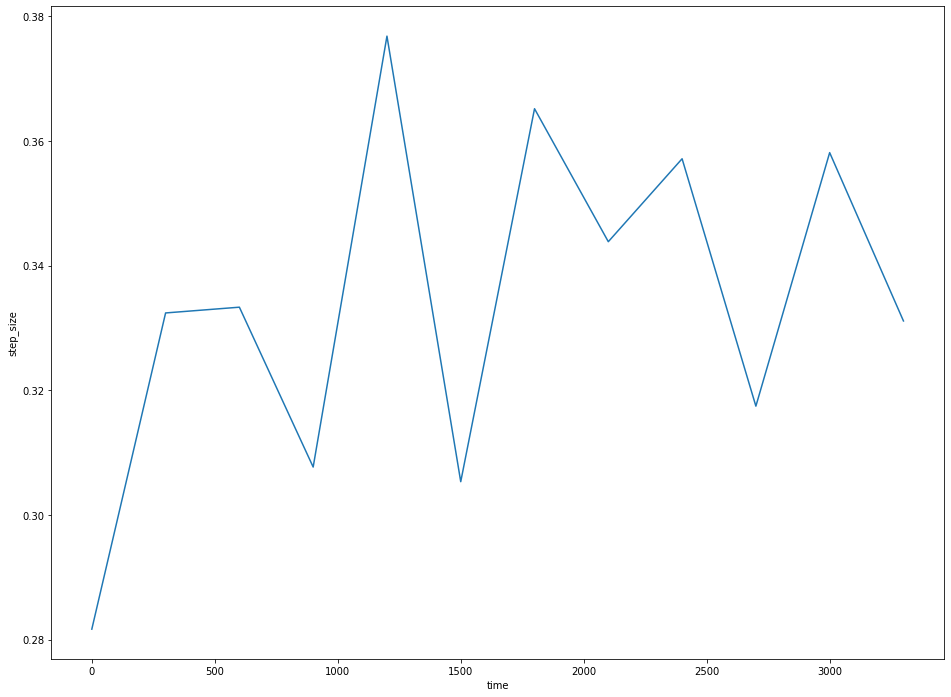

In [11]:
import itertools

mm = an.loaded_margins[0]
acc = []
for r in mm:
    if '_records' in r:
        acc += list(r['_records'])
    else:
        acc.append(r)

factor = 3*60
srter = lambda x: (x['time'], x['steps'])
acc.sort(key=srter)

times = []
step_size = []
for g, k in itertools.groupby(acc, key=lambda x: int(x['time']/factor)):
    trecs = list(k)
    min_rec, max_rec = trecs[0], trecs[-1]
    dist_el = max_rec['dist'] - min_rec['dist']

    if dist_el <= 0:
        logger.warning('Elapsed distance is zero for %s: %s' % (g,dist_el,))
        continue

    steps_el = max_rec['steps'] - min_rec['steps']
    cstep_size = dist_el*10 / steps_el
    if cstep_size < 0.01:
        continue

    times.append(min_rec['time'])
    step_size.append(cstep_size)

plt.figure(figsize=(16, 12))
data_plot = pd.DataFrame({"time": times, "step_size": step_size})
print(data_plot)
sns.lineplot(x = "time", y = "step_size", data=data_plot)
plt.show()

Speed:  0.5, ccal:   44.44, net:   20.27
Speed:  1.0, ccal:   52.17, net:   28.00
Speed:  1.5, ccal:   58.55, net:   34.38
Speed:  2.0, ccal:   63.98, net:   39.80
Speed:  2.5, ccal:   68.83, net:   44.66
Speed:  3.0, ccal:   73.50, net:   49.33
Speed:  3.5, ccal:   78.38, net:   54.21
Speed:  4.0, ccal:   83.85, net:   59.68
Speed:  4.5, ccal:   90.29, net:   66.12
Speed:  5.0, ccal:   98.10, net:   73.93
Speed:  5.5, ccal:  107.67, net:   83.49
Speed:  6.0, ccal:  119.37, net:   95.20


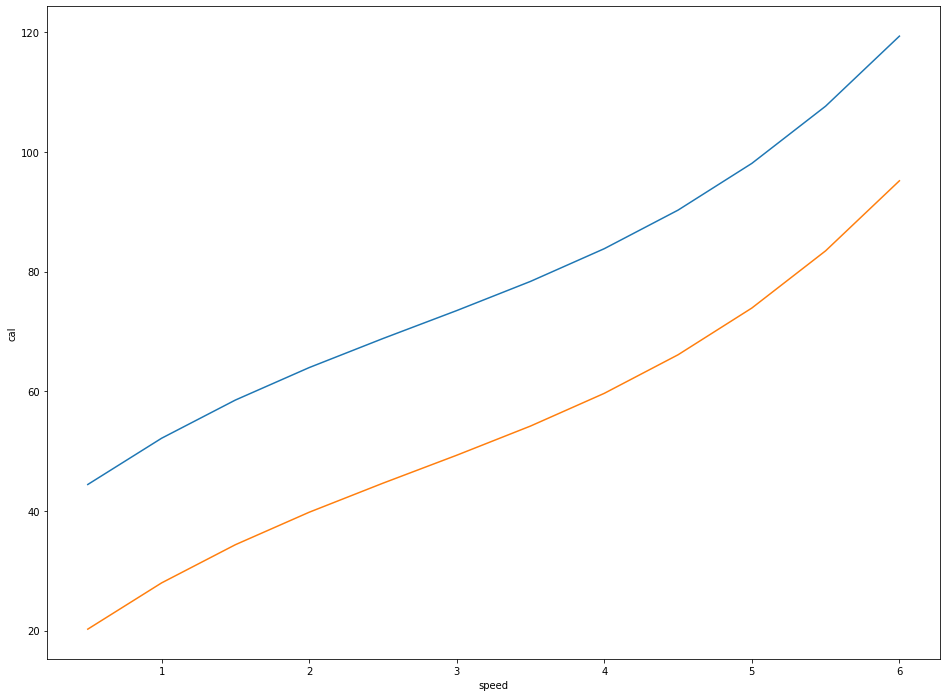

In [25]:
# calorie burn depending on the speed
def compute_walk_burn(profile):
    cal_data = []
    for speed in range(5, 61, 5):
        el_time = 60 * 15  # mins
        ccal = (el_time / 60) * calories_walk2_minute(speed/10, profile.weight, 0.00)
        ccal_net = ccal - (el_time / 60) * calories_rmrcb_minute(profile.weight, profile.height,
                                                                 profile.age, profile.male)
        cal_data.append({'speed': speed/10, 'cal': ccal, 'net':ccal_net})
        print('Speed: %4.1f, ccal: %7.2f, net: %7.2f' % (speed/10, ccal, ccal_net))

    plt.figure(figsize=(16, 12))
    data_plot = pd.DataFrame(cal_data)
    sns.lineplot(x = "speed", y = "cal", data=data_plot)
    sns.lineplot(x = "speed", y = "net", data=data_plot)
    plt.show()


compute_walk_burn(an.profile)

Speed:  0.5, ccal:   44.44, net:   20.27
Speed:  1.0, ccal:   52.17, net:   28.00
Speed:  1.5, ccal:   58.55, net:   34.38
Speed:  2.0, ccal:   63.98, net:   39.80
Speed:  2.5, ccal:   68.83, net:   44.66
Speed:  3.0, ccal:   73.50, net:   49.33
Speed:  3.5, ccal:   78.38, net:   54.21
Speed:  4.0, ccal:   83.85, net:   59.68
Speed:  4.5, ccal:   90.29, net:   66.12
Speed:  5.0, ccal:   98.10, net:   73.93
Speed:  5.5, ccal:  107.67, net:   83.49
Speed:  6.0, ccal:  119.37, net:   95.20


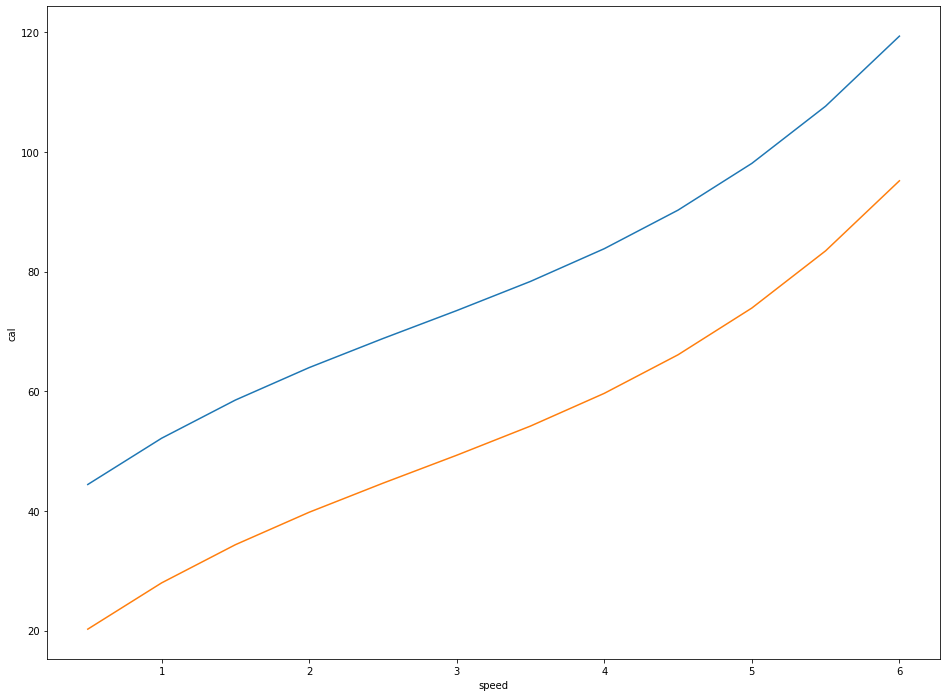

In [26]:
ad = StatsAnalysis()
ad.profile_file = '/Users/dusanklinec/workspace/ph4-walkingpad/profile.json'
ad.load_profile()

compute_walk_burn(ad.profile)


In [450]:
import random, sys
from scipy import stats
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


m = 0b0011111111111101  # modulus, shorter version of yours 0x7ffe1 with a similar concept, also a prime

def rr(ran, dist=False):  # fully random 16 bits
  a = [0 for _ in range(2**16)] if not dist else []
  for _ in range(ran):
    x = random.getrandbits(16) 
    if dist:
        a.append(x)
    else:
        a[x] += 1 
  return a 


def mm(ran, st=0, dist=False):
  a = [0 for _ in range(m)] if not dist else []
  for i in range(ran): 
    x = random.randint(0, m-1) if st == 0 else (random.getrandbits(st) % m) 
    if dist:
        a.append(x)
    else:
        a[x] += 1 
  return a 
                                                                                                               

def mr(ran, st=0, dist=False): 
  tp = (2**16) // m
  rm = (2**16) - tp * m    
  a = [0 for _ in range(2**16)] if not dist else []
  for i in range(ran): 
    #y = random.getrandbits(16) 
    #z = random.getrandbits(st) % m  # not uniform on m
    z = random.randint(0, m-1 - st)  # uniform [0, m-1]
    
    # clear modulus space (no neg. vals), then add
    # problem: absolutely weird shape, like a game logo :D
    #x = (y - m if y >= m else y) + z
    
    # moduli multiplies, resembles distrib, 4*m is only in small counts compared to {0,1,2,3}*m
    # problem: no occurences for 0xfff4+, 4*m and above, and wraps over by adding +z if z > 2**16 - 4m
    # x = (y - (y % m)) + z
    
    # also not working
    x = (z + (random.getrandbits(2) << 14)) #^ (random.getrandbits(2))
    
    # works: randomized moduli offset, higher only if does not wrap 
    # works for: z = random.getrandbits(st) % m
    #x = (m * random.randint(0, tp if z < rm else tp-1)) + z
    
#     if x > 0xffff:  # should not happen, skews distribution
#         sys.stdout.write(hex(x) + ', ')
    
    if dist:
        a.append(x & 0xffff)
    else:
        a[x & 0xffff] += 1 
  return a 

In [456]:
rvs1 = rr(2**30, dist=True)
rvs3 = rr(2**24, dist=True)

In [ ]:
# rvs1 = rr(2**16, dist=True)
# rvs2 = rr(2**16, dist=True)

#rvs1 = mm(2**22, dist=True)
#rvs2 = mm(2**22, 14, dist=True)

# rvs1 = rr(2**22, dist=True)
# rvs2 = mm(2**22, 14, dist=True)

# rvs1 = rr(2**20, dist=True)
# rvs2 = mr(2**20, 0, dist=True)
# print('computing KS...')
# print(stats.ks_2samp(rvs1, rvs2))

rvs2 = mr(2**30, 0, dist=True)
print(stats.ks_2samp(rvs1, rvs2))
print(stats.ks_2samp(rvs1, rvs3))
print(stats.ttest_ind(rvs1, rvs2))
print(stats.ttest_ind(rvs1, rvs3))


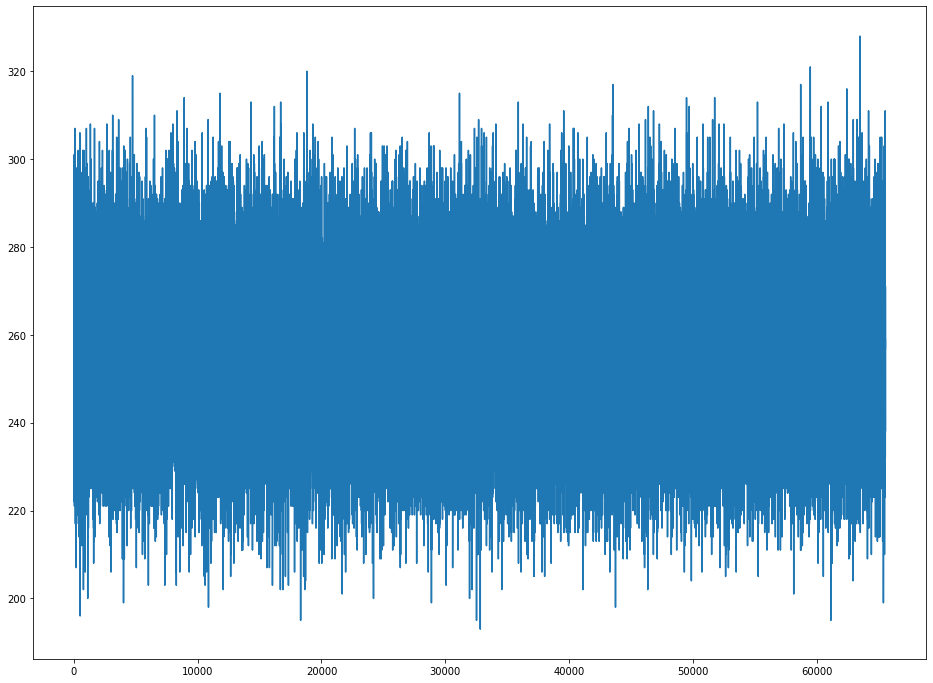

In [363]:
ar = rr(2**24)
plt.figure(figsize=(16, 12))
sns.lineplot(x=list(range(2**16)), y=ar)
plt.show()

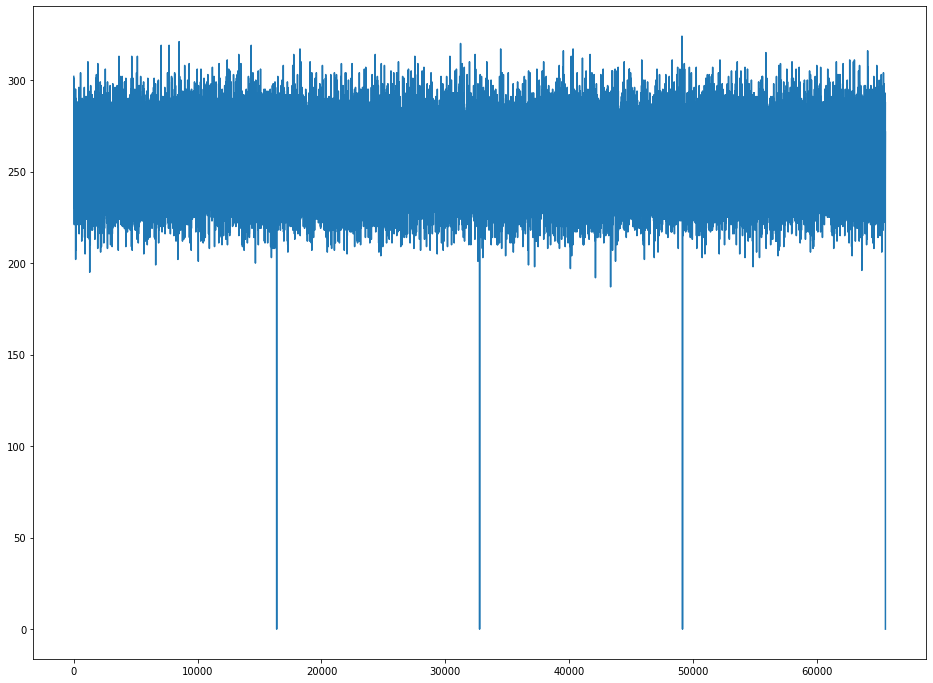

In [451]:
am = mr(2**24, st=0)
plt.figure(figsize=(16, 12))
sns.lineplot(x=list(range(2**16)), y=am)
plt.show()

In [ ]:
am2 = mr(2**24, 15)
plt.figure(figsize=(16, 12))
sns.lineplot(x=list(range(2**16)), y=am2)
plt.show()

In [ ]:
am3 = mr(2**24, 14)
plt.figure(figsize=(16, 12))
sns.lineplot(x=list(range(2**16)), y=am3)
plt.show()

In [ ]:
am4 = mr(2**24, 13)
plt.figure(figsize=(16, 12))
sns.lineplot(x=list(range(2**16)), y=am4)
plt.show()

In [ ]:
plt.figure(figsize=(16, 12))
sns.lineplot(x=list(range(m)), y=mm(2**24, 0))
plt.show()

In [ ]:
plt.figure(figsize=(16, 12))
sns.lineplot(x=list(range(m)), y=mm(2**24, 14))
plt.show()

In [ ]:
plt.figure(figsize=(16, 12))
sns.lineplot(x=list(range(m)), y=mm(2**24, 16))
plt.show()

In [435]:
ctr = 0
for i,x in enumerate(am):
    if x < 180 or x > 350:
        ctr += 1
        print("i: %6d, bin: %16s, hex: %06x, ctr: %s" % (i, (bin(i)[2:]).rjust(16,'0'), i, x))
    if ctr > 200:
        break

i:  16380, bin: 0011111111111100, hex: 003ffc, ctr: 55
i:  16381, bin: 0011111111111101, hex: 003ffd, ctr: 79
i:  16382, bin: 0011111111111110, hex: 003ffe, ctr: 51
i:  16383, bin: 0011111111111111, hex: 003fff, ctr: 55
i:  32764, bin: 0111111111111100, hex: 007ffc, ctr: 62
i:  32765, bin: 0111111111111101, hex: 007ffd, ctr: 76
i:  32766, bin: 0111111111111110, hex: 007ffe, ctr: 60
i:  32767, bin: 0111111111111111, hex: 007fff, ctr: 67
i:  49148, bin: 1011111111111100, hex: 00bffc, ctr: 80
i:  49149, bin: 1011111111111101, hex: 00bffd, ctr: 52
i:  49150, bin: 1011111111111110, hex: 00bffe, ctr: 61
i:  49151, bin: 1011111111111111, hex: 00bfff, ctr: 73
i:  65532, bin: 1111111111111100, hex: 00fffc, ctr: 56
i:  65533, bin: 1111111111111101, hex: 00fffd, ctr: 74
i:  65534, bin: 1111111111111110, hex: 00fffe, ctr: 66
i:  65535, bin: 1111111111111111, hex: 00ffff, ctr: 59


In [134]:
hex(m)

'0x3ffd'

In [248]:
[hex(m*i) for i in range(6)]

['0x0', '0x3ffd', '0x7ffa', '0xbff7', '0xfff4', '0x13ff1']

In [312]:
m-2**14

-3